&nbsp;&nbsp;&nbsp;&nbsp;The following analysis uses tensorflow on the gpu to run. The intention is to run the final model, which has over 500k parameters to train in the network, in a feasible amount of computation time. On my Nvidia Geoforce 980ti, the model takes about 17 seconds per epoch for 20 epochs. Since the reported time in the record model's paper suggests a 14 hour training period over 800 epochs, it's possible they used a more robust optimizer and loss function that are computationally harder (e.g. using full gradient descent rather than stochastic gradient descent). They also used an adapted learning rate to fine tune the minimums in the loss function towards the end.

In [1]:
# Source: https://stackoverflow.com/questions/47286441/only-import-keras-takes-10gb-in-gpu
# This added cell fixes an issue with keras loading onto the gpu's RAM preventing larger batch sizes
# and more complicated models.

import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
from keras import backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
session = tf.Session(config=config)
K.set_session(session)

Using TensorFlow backend.


&nbsp;&nbsp;&nbsp;&nbsp;First, we import the mnist data from keras. Each image is 28x28 with intensity from white (0) to black (255). Since the basic model is fully connected the data is reshaped so the second dimension is a list of the intensities rather than the matrix of intensities. The labels are also converted to 1-hot matrices so that softmax has a distinct classification to maximize trigger.

In [12]:
from tensorflow import keras

num_classes = 10

img_rows = 28
img_cols = 28

mnist = keras.datasets.mnist
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()

#train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
#test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# For basic model comparison
train_images = train_images.reshape(train_images.shape[0],img_rows*img_cols)
test_images = test_images.reshape(test_images.shape[0],img_rows*img_cols)

# Normalize intensity values
train_images /= 255.0
test_images /= 255.0

# Convert the labels to 1-hot
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

We can build our first network which is a basic 1 layer fully connected model (784N-15N-10N)

In [20]:
from __future__ import print_function
import keras
import keras.models as km
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import optimizers

import numpy as np
import tensorflow as tf

#input_shape = (img_rows,img_cols,1)
input_shape = (img_rows*img_cols,1)

model = km.Sequential()
model.add(Dense(15, input_dim=img_rows*img_cols))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 15)                11775     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                160       
Total params: 11,935
Trainable params: 11,935
Non-trainable params: 0
_________________________________________________________________


Compile and train the basic model.

In [21]:
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])

batch_size = 16
epochs= 20
history = model.fit(train_images, train_labels,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(test_images,test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 7s 121us/step - loss: 0.0770 - acc: 0.4228 - val_loss: 0.0609 - val_acc: 0.5960
Epoch 2/20
60000/60000 [==============================] - 7s 115us/step - loss: 0.0520 - acc: 0.6532 - val_loss: 0.0433 - val_acc: 0.7278
Epoch 3/20
60000/60000 [==============================] - 7s 118us/step - loss: 0.0381 - acc: 0.7784 - val_loss: 0.0322 - val_acc: 0.8305
Epoch 4/20
60000/60000 [==============================] - 7s 115us/step - loss: 0.0301 - acc: 0.8335 - val_loss: 0.0264 - val_acc: 0.8591
Epoch 5/20
60000/60000 [==============================] - 7s 115us/step - loss: 0.0259 - acc: 0.8533 - val_loss: 0.0232 - val_acc: 0.8698
Epoch 6/20
60000/60000 [==============================] - 7s 115us/step - loss: 0.0234 - acc: 0.8636 - val_loss: 0.0212 - val_acc: 0.8774
Epoch 7/20
60000/60000 [==============================] - 7s 117us/step - loss: 0.0217 - acc: 0.8708 - val_loss: 0.0199 - 

&nbsp;&nbsp;&nbsp;&nbsp;We'll test the accuracy from the basic model using a confusion matrix (with in-order labels). We can tell from the training vs. validation accuracy plot that the model hasn't suffered from overfitting.

Confusion matrix: 
 [[ 960    0    5    2    0    2    5    1    5    0]
 [   0 1102    4    6    0    0    5    2   16    0]
 [  14    1  908   12   18    0   18   16   39    6]
 [   3    0   22  907    1   29    3   17   20    8]
 [   2    3    4    1  912    0   14    2    6   38]
 [  17    4    4   39   14  727   18   13   51    5]
 [  21    3    3    0   14   14  897    1    5    0]
 [   4   14   30    6   13    1    0  929    2   29]
 [   7    7   10   21    8   21   12   10  864   14]
 [  10    6    4    8   44   13    0   25   12  887]]
Classification accuracy:  0.9093


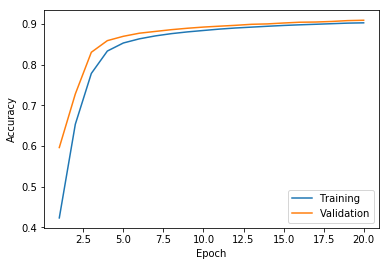

In [30]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(test_images, batch_size=batch_size)
# argmax determines which class had the most weight (e.g. predicted)
c = confusion_matrix(test_labels.argmax(axis=1), y_pred.argmax(axis=1), labels=[0,1,2,3,4,5,6,7,8,9])
accuracy = np.diagonal(c).sum()/c.sum()

print("Confusion matrix: \n", c)
print("Classification accuracy: ", accuracy)


train_acc = history.history['acc']
val_acc = history.history['val_acc']

xs = [i+1 for i in range(epochs)]

plt.plot(xs,train_acc)
plt.plot(xs,val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

We can build our second network which is a convolution network that utilizes two convolution layers and two pooling layers. The architecture slightly differs from one column in the record model since the record used a dataset with 29x29 images, possibly rescaling the original NIST sets themselves (1x29x29-20C4-MP2-40C5-MP3-150N-10N).

In [32]:
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows,img_cols,1)

model = km.Sequential()

model.add(Conv2D(20, kernel_size=(4, 4),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(800, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dense(150))
model.add(Flatten())
model.add(Dense(num_classes, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 25, 25, 20)        340       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 800)         400800    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 800)         0         
_________________________________________________________________
dense_16 (Dense)             (None, 2, 2, 150)         120150    
_________________________________________________________________
flatten_6 (Flatten)          (None, 600)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                6010      
Total para

Compile and train the advanced model.

In [33]:
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])

batch_size = 16
epochs= 20
history = model.fit(train_images, train_labels,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(test_images,test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 17s 276us/step - loss: 0.0874 - acc: 0.5076 - val_loss: 0.0827 - val_acc: 0.7081
Epoch 2/20
60000/60000 [==============================] - 16s 271us/step - loss: 0.0605 - acc: 0.6966 - val_loss: 0.0325 - val_acc: 0.8523
Epoch 3/20
60000/60000 [==============================] - 16s 270us/step - loss: 0.0227 - acc: 0.8848 - val_loss: 0.0156 - val_acc: 0.9111
Epoch 4/20
60000/60000 [==============================] - 16s 271us/step - loss: 0.0143 - acc: 0.9191 - val_loss: 0.0115 - val_acc: 0.9343
Epoch 5/20
60000/60000 [==============================] - 16s 268us/step - loss: 0.0114 - acc: 0.9335 - val_loss: 0.0096 - val_acc: 0.9424
Epoch 6/20
60000/60000 [==============================] - 16s 270us/step - loss: 0.0097 - acc: 0.9423 - val_loss: 0.0083 - val_acc: 0.9507
Epoch 7/20
60000/60000 [==============================] - 16s 272us/step - loss: 0.0086 - acc: 0.9484 - val_loss: 0.

Similarly, we can test accuracy using a confusion matrix and verify the model isn't overfitted.

Confusion matrix: 
 [[ 969    2    0    0    1    4    1    2    1    0]
 [   0 1123    4    3    0    1    1    0    3    0]
 [   5    0 1004    1    1    0    1   14    4    2]
 [   0    0    5  990    0    3    0    7    3    2]
 [   2    2    1    1  956    1    4    3    2   10]
 [   4    0    0    7    1  873    2    2    3    0]
 [   7    2    0    1    6    5  935    0    2    0]
 [   1    3   15    4    0    1    0  999    2    3]
 [   4    0    2    3    4    2    3    5  945    6]
 [   5    2    0    4    2    5    1    5    8  977]]
Classification accuracy:  0.9771


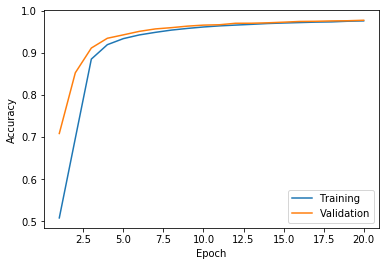

In [34]:
y_pred = model.predict(test_images, batch_size=batch_size)
# argmax determines which class had the most weight (e.g. predicted)
c = confusion_matrix(test_labels.argmax(axis=1), y_pred.argmax(axis=1), labels=[0,1,2,3,4,5,6,7,8,9])
accuracy = np.diagonal(c).sum()/c.sum()

print("Confusion matrix: \n", c)
print("Classification accuracy: ", accuracy)


train_acc = history.history['acc']
val_acc = history.history['val_acc']

xs = [i+1 for i in range(epochs)]

plt.plot(xs,train_acc)
plt.plot(xs,val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

It can be noted that the accuracies of both models had not yet reached their full potential, still garnering marginal improvements in later epochs. Perhaps this where a more refined learning rate could help us achieve minimized loss faster and we could also train for much longer until convergence.